## Project Description

In this project, a model that can predict the probability of a customer to order a product from a given currentbugroupname in the next 3 days by using the past orders and user actions such as products visited, search terms, user favorites, and products added to the basket in addition to product details and user demographics.

Note: a user can make a purchase from multiple **currentbugroupname**'s during the testing period.


## Table of Contents <a id='table_of_contents'></a>
0. [Import Packages](#imports_packages)
1. [Data Exploration & Cleaning](#exploration)  
    1.2. [Product Information](#df_product)  
    1.2. [Purchase History](#df_trx)  
    1.3. [Demographical Data](#df_demo)  
    1.4. [Purchase Data for the Next 3 Days](#df_future)  
    1.5. [Dataframes on User Actions](#df_action)
2. [Data Preparation](#preparation)  
    2.1. [Grouping and Aggregating User Actions](#grouping_actions)  
    2.2. [Product Matrix](#matrix)  
    2.3. [Creating Feature Columns](#create_feature)  
    2.4. [Normalizing](#normalize)  
3. [Benchmark Modelling](#modelling)  
4. [Model Evaluation](#evaluation)


# 0. Import Packages <a id='imports_packages'></a>
[Back to top](#table_of_contents)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from itertools import product
import datetime 

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix

from sklearn import preprocessing

## 1. Data Exploration & Cleaning <a id='exploration'></a>
[Back to top](#table_of_contents)

Below there will be several subtitles referring to the files I have been provided.

### 1.1. Product Information <a id='df_product'></a>
[Back to top](#table_of_contents)

Products' information data
- **contentid:** Unique ID given to the product.
- **currentbugroupname:** Business Group Name (can be thought of as a broader category) of the product.
- **brandid:** Unique ID given to the brand of the product.
- **gender:** Target gender group of the product.
- **age:** Target age group of the product.
- **title:** Title of the product.
- **categoryname:** Category name of the product.


In [2]:
df_product = pd.read_csv('df_product.csv')
print(df_product.shape)
df_product.head(5)


(1441753, 7)


,contentid,currentbugroupname,brandid,gender,age,title,categoryname
0,40100964,Ayakkabı & Çanta,37787,Erkek,Yetişkin,Siyah Kauçuk Taban Büyük Numara Spor Ayakkab R...,Klasik Ayakkabı
1,40427970,Branded Tekstil,169,Kadın,Yetişkin,Kadın Siyah Çizgili Cepli Kuşaklı Pantolon,Pantolon
2,41026644,FMCG,20150,Unisex,Yetişkin,Color Growth Healt Formula (800-1200) 100gr Aç...,Akvaryum Balık Yemleri
3,41227029,Branded Tekstil,11806,Kadın,Yetişkin,Kadın Pamuk Paçalı Ribana Külot B005,Külot
4,40770080,Ev,2195,Unisex,Yetişkin,Suki - Sushi Seti 8 Parça,Tabak


<AxesSubplot:>

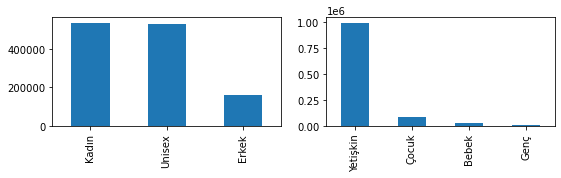

In [3]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[9, 2])
df_product['gender'].value_counts().plot(kind='bar', ax=axes[0])
df_product['age'].value_counts().plot(kind='bar', ax=axes[1])

In [4]:
print(df_product.currentbugroupname.unique())
print(df_product.currentbugroupname.nunique())

['Ayakkabı & Çanta' 'Branded Tekstil' 'FMCG' 'Ev' 'GAS' 'GM' 'Elektronik'
 'Kozmetik' 'Aksesuar & Saat & Gözlük' 'Private Label' 'Mobilya' 'UNKNOWN'
 'Digital Goods']
13


Note that there is a bugroupname called UNKNOWN.

In [5]:
df_product.isna().value_counts()

contentid  currentbugroupname  brandid  gender  age    title  categoryname
False      False               False    False   False  False  False           1127957
                                        True    True   False  False            219170
                                        False   True   False  False             91789
                                        True    False  False  False              2249
                                        False   False  True   False               341
                                        True    True   True   False               163
                                        False   True   True   False                84
dtype: int64

In df_product there are nearly 300,000 items that we do not have information regarding the target group such as gender or age. Since I will create my model mainly considering the historical purchase data, I anticipate that target group of the items do not necessarily have an effect on the model performances. I decided not to use these columns as a feature column. Another option would be removing the rows with NaN however the amount of data points to be removed is significant considering the total amount.

In [6]:
#removing the columns named title, gender, age, and brandid and creating a new data frame called product list.
product_list = df_product.drop(['brandid', 'age', 'gender', 'title'], axis=1)
product_list[product_list.isna()==False]

,contentid,currentbugroupname,categoryname
0,40100964,Ayakkabı & Çanta,Klasik Ayakkabı
1,40427970,Branded Tekstil,Pantolon
2,41026644,FMCG,Akvaryum Balık Yemleri
3,41227029,Branded Tekstil,Külot
4,40770080,Ev,Tabak
...,...,...,...
1441748,34244637,Kozmetik,Parfüm
1441749,49936434,GM,Diğer Oda Aksesuarları
1441750,51658518,Branded Tekstil,Tesettür Elbise
1441751,52218496,Ayakkabı & Çanta,El Çantası


### 1.2. Demographical Data <a id='df_demo'></a>
[Back to top](#table_of_contents)

Users' demographics data
- **userid:** Unique ID given to the user.
- **gender:** Specified gender of the user.
- **age:** Specified age of the user.
- **tenure:** Membership age of the user.

In [7]:
df_demo = pd.read_csv('df_demo.csv')
df_demo.describe()

,userid,age,tenure
count,4.080700e+04,25204.000000,40807.000000
mean,1.922032e+07,214.540351,41.772269
std,1.127785e+07,545.518265,39.807200
min,2.086000e+03,-48.000000,0.000000
25%,1.106792e+07,27.000000,11.000000
50%,1.753366e+07,35.000000,24.000000
75%,2.722423e+07,120.000000,66.000000
max,4.462565e+07,2019.000000,129.000000


In [8]:
print(df_demo[df_demo.age<=0].shape)
print(df_demo[df_demo.age<100].shape)
print(df_demo.shape)

(4, 4)
(18077, 4)
(40807, 4)


I chose not to delete any rows from demographical data because they are not essential for the model at this stage.

<AxesSubplot:>

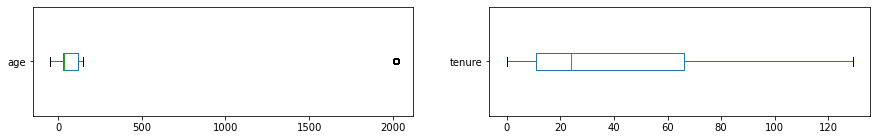

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[15, 2])
df_demo.plot.box(ax=axes[0], x='userid', y='age', vert=False)
df_demo.plot.box(ax=axes[1], x='userid', y='tenure', vert=False)

The unit of tenure was assumed to be weeks considering the fact that the company was founded in 2010. 
Age of the users looks quite misleading since there are certainly rows with unrealistitic values such as >100 and =<0 (perhaps <18 too>). While 50% of the users are younger than 35 sounds realistic, min age=-48 and max age=2019 are completely mistaken.

I do not delete any rows in accordance with the ages because I do not want to miss 18081 of 40807 datapoints. I would reconsider this option if I definetely were to use users' age. Instead, I will use the tenure since I assume that tenure information comes from the company's databases while the stakes are high that people use fake birth dates during their user registration or that mistakes may have occured while extracting or producing the data.


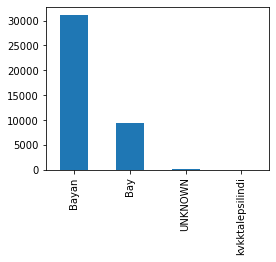

Bayan               31202
Bay                  9378
UNKNOWN               218
kvkktalepsilindi        9
Name: gender, dtype: int64

In [10]:
fig, plt.subplots(figsize=[4, 3])
df_demo['gender'].value_counts().plot(kind='bar')
plt.show()

df_demo.gender.value_counts() #9 rows with unrealistic genders.

In [11]:
demo_list = df_demo.drop(['age'], axis=1)
demo_list.isna().value_counts()

userid  gender  tenure
False   False   False     40807
dtype: int64

### 1.3. Purchase History <a id='df_trx'></a>
[Back to top](#table_of_contents)

Users' product purchase data 
- **orderdate:** Date and hour of the "product purchase" event.
- **quantity:** How many units of this product is purchased during this orderdate.
- **price:** Price of the purchased product.


In [12]:
df_trx = pd.read_csv('df_trx.csv')
print(df_trx.head())
df_trx.describe()

     userid   contentid                orderdate  quantity   price
0  16049866  49489653.0  2020-10-31 03:00:00.000         1  199.95
1  14167874  42484094.0  2020-10-31 03:00:00.000         1   69.99
2  14167874  39373962.0  2020-10-31 03:00:00.000         1   69.99
3  13918576  32765999.0  2020-10-31 03:00:00.000         1   43.99
4  10323124  46471016.0  2020-10-31 03:00:00.000         1   58.32


,userid,contentid,quantity,price
count,3.815360e+05,3.815250e+05,381536.000000,381536.000000
mean,1.577879e+07,3.351160e+07,1.093795,83.813233
std,1.040496e+07,1.626854e+07,0.495301,245.595041
min,2.086000e+03,4.869100e+04,1.000000,0.080000
25%,8.293054e+06,3.162247e+07,1.000000,26.550000
50%,1.389528e+07,3.775790e+07,1.000000,48.630000
75%,2.225621e+07,4.612945e+07,1.000000,82.500000
max,4.446816e+07,5.590954e+07,10.000000,16690.610000


In [13]:
# any duplicated rows or rows with NaN values were deleted.
df_trx = df_trx.drop_duplicates()
df_trx = df_trx.dropna()

In [14]:
df_trx.head(5)

,userid,contentid,orderdate,quantity,price
0,16049866,49489653.0,2020-10-31 03:00:00.000,1,199.95
1,14167874,42484094.0,2020-10-31 03:00:00.000,1,69.99
2,14167874,39373962.0,2020-10-31 03:00:00.000,1,69.99
3,13918576,32765999.0,2020-10-31 03:00:00.000,1,43.99
4,10323124,46471016.0,2020-10-31 03:00:00.000,1,58.32


Below, I create a new dataframe called order_history where I store information about the orders in the past. 
- Creating date and hour column.
- Adding currentbugroupname with left_join to order_history from product_list.

In [15]:
order_history = df_trx.copy()
order_history = order_history.merge(product_list, on='contentid', how='left') #adding product information
order_history = order_history.merge(demo_list, on='userid', how='left') #adding product information
order_history['orderdate'] = pd.to_datetime(order_history['orderdate'])
order_history['order_hour'] = order_history.orderdate.dt.hour
order_history['order_date'] = order_history.orderdate.dt.date
order_history['which_day'] = order_history.orderdate.dt.weekday #the day of the week with Monday=0, Sunday=6.
order_history.head()

,userid,contentid,orderdate,quantity,price,currentbugroupname,categoryname,gender,tenure,order_hour,order_date,which_day
0,16049866,49489653.0,2020-10-31 03:00:00,1,199.95,Branded Tekstil,Sweatshirt,Bayan,30,3,2020-10-31,5
1,14167874,42484094.0,2020-10-31 03:00:00,1,69.99,Private Label,Kazak,Bayan,37,3,2020-10-31,5
2,14167874,39373962.0,2020-10-31 03:00:00,1,69.99,Private Label,Kazak,Bayan,37,3,2020-10-31,5
3,13918576,32765999.0,2020-10-31 03:00:00,1,43.99,Ev,Tava&Tava Seti,Bayan,39,3,2020-10-31,5
4,10323124,46471016.0,2020-10-31 03:00:00,1,58.32,Private Label,Gömlek,Bayan,79,3,2020-10-31,5


NaN rows were deleted however there still might be some rows having NaN for some of the feature columns.

In [16]:
order_history.isna().value_counts()

userid  contentid  orderdate  quantity  price  currentbugroupname  categoryname  gender  tenure  order_hour  order_date  which_day
False   False      False      False     False  False               False         False   False   False       False       False        288209
                                               True                True          False   False   False       False       False         90729
dtype: int64

There are lots of NaN in the 'currentbugroupname'. I will remove these rows.

In [17]:
order_history = order_history.dropna(subset=['currentbugroupname'])
order_history.isna().value_counts()

userid  contentid  orderdate  quantity  price  currentbugroupname  categoryname  gender  tenure  order_hour  order_date  which_day
False   False      False      False     False  False               False         False   False   False       False       False        288209
dtype: int64

In [18]:
pd.date_range(order_history.order_date.min(), order_history.order_date.max())

DatetimeIndex(['2020-10-01', '2020-10-02', '2020-10-03', '2020-10-04',
               '2020-10-05', '2020-10-06', '2020-10-07', '2020-10-08',
               '2020-10-09', '2020-10-10', '2020-10-11', '2020-10-12',
               '2020-10-13', '2020-10-14', '2020-10-15', '2020-10-16',
               '2020-10-17', '2020-10-18', '2020-10-19', '2020-10-20',
               '2020-10-21', '2020-10-22', '2020-10-23', '2020-10-24',
               '2020-10-25', '2020-10-26', '2020-10-27', '2020-10-28',
               '2020-10-29', '2020-10-30', '2020-10-31', '2020-11-01'],
              dtype='datetime64[ns]', freq='D')

In the order_history, we have data from October 01 to November 01.

<AxesSubplot:xlabel='count', ylabel='which_day'>

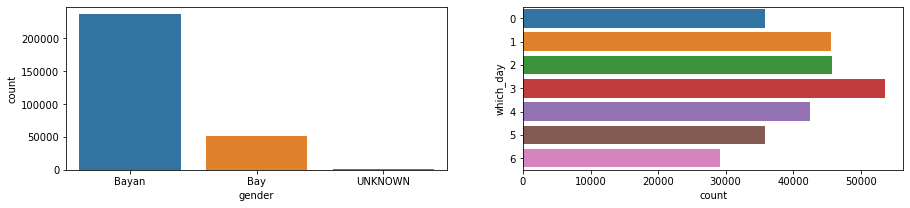

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=[15, 3])
sns.countplot(ax=axes[0], data=order_history[order_history.gender!='kvkktalepsilindi'], x='gender')
sns.countplot(ax=axes[1],data=order_history, y='which_day')

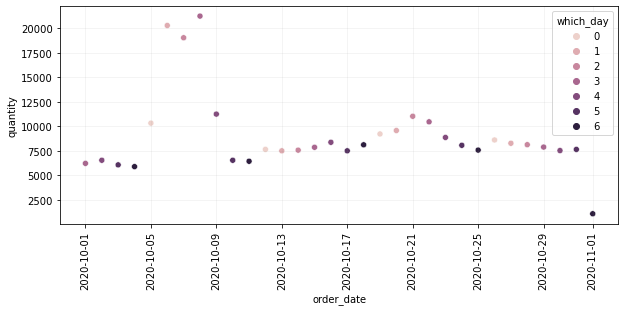

In [20]:
order_history_by_date = order_history.groupby(['order_date']).agg({'quantity':'count'}).reset_index()
fig, ax = plt.subplots(figsize=(10,4))
order_history_by_date['order_date'] = pd.to_datetime(order_history_by_date['order_date'])
order_history_by_date['which_day'] = order_history_by_date.order_date.dt.weekday #the day of the week with Monday=0, Sunday=6.
ax = sns.scatterplot(data=order_history_by_date, x='order_date', y='quantity', hue='which_day') #Monday=0, Sunday=6
ax.grid(axis='both', color='gray', alpha=0.1)
plt.xticks(rotation=90)
locs, labels = plt.xticks() 

<AxesSubplot:xlabel='count', ylabel='currentbugroupname'>

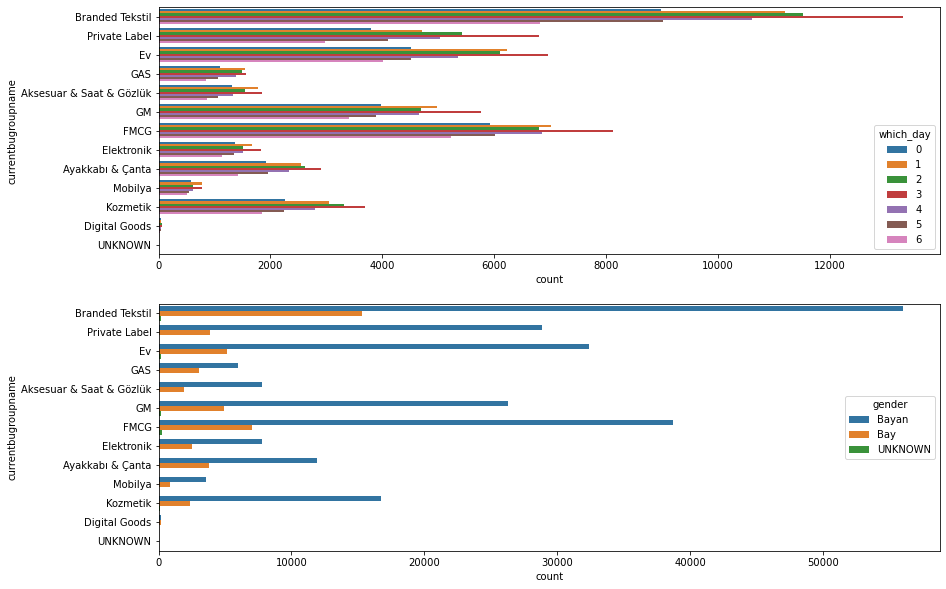

In [21]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14,10))
sns.countplot(ax=axes[0], data=order_history[order_history.gender!='kvkktalepsilindi'], y='currentbugroupname', hue='which_day')
sns.countplot(ax=axes[1], data=order_history[order_history.gender!='kvkktalepsilindi'], y='currentbugroupname', hue='gender')

### 1.4. Purchase Data for the Next 3 Days <a id='df_future'></a>
[Back to top](#table_of_contents)

df_target_train: Purchase data for **training** users in the next 3 days
df_test: Purchase prediction data for **test** users in the next 3 days
- **probability:** Users purchase probability. (between 0 and 1)
- **target:** Final verdict for the user's purchase decision (0 or 1)

#### Training Set

In [22]:
df_target_train = pd.read_csv('df_target_train.csv')
print(df_target_train.head(5))

# verdict 1
df_target_train['target'] = 1
df_target_train.head()

     userid currentbugroupname
0  28704634                 GM
1  13506108                 Ev
2   5893128                NaN
3  15209082            Mobilya
4   1109976           Kozmetik


,userid,currentbugroupname,target
0,28704634,GM,1
1,13506108,Ev,1
2,5893128,NaN,1
3,15209082,Mobilya,1
4,1109976,Kozmetik,1


In [23]:
print(df_target_train.currentbugroupname.unique())
print(product_list.currentbugroupname.unique())

['GM' 'Ev' nan 'Mobilya' 'Kozmetik' 'Aksesuar & Saat & Gözlük'
 'Private Label' 'FMCG' 'Ayakkabı & Çanta' 'GAS' 'Branded Tekstil'
 'Elektronik' 'Digital Goods']
['Ayakkabı & Çanta' 'Branded Tekstil' 'FMCG' 'Ev' 'GAS' 'GM' 'Elektronik'
 'Kozmetik' 'Aksesuar & Saat & Gözlük' 'Private Label' 'Mobilya' 'UNKNOWN'
 'Digital Goods']


#### Test Set

In [24]:
df_test = pd.read_csv('df_test.csv')
df_test = df_test.drop(['probability'], axis=1)
df_test = df_test.drop(['target'], axis=1)
df_test.head(5)

,userid,currentbugroupname
0,20152944,Private Label
1,6662068,Private Label
2,11941706,Private Label
3,12406170,Private Label
4,20939786,Private Label


In [25]:
print(df_test.currentbugroupname.unique())
df_test.head()

['Private Label' 'Kozmetik' 'Ev' 'Branded Tekstil' 'Ayakkabı & Çanta'
 'Elektronik' 'GM' 'FMCG' 'Mobilya' 'GAS' 'Aksesuar & Saat & Gözlük'
 'Digital Goods']


,userid,currentbugroupname
0,20152944,Private Label
1,6662068,Private Label
2,11941706,Private Label
3,12406170,Private Label
4,20939786,Private Label


### 1.5. Dataframes on User Actions <a id='df_actions'></a>
(actions: adding to favorite, visiting the item page, searching the item, adding to basket)

[Back to top](#table_of_contents)

- **partition_date:** Date and hour of the "action" event.
- **productdetailcount:** How many times this event occured during this partition_date.
- **addtobasket_count:** How many times this event occured during this partition_date.
- **fav_count:** How many times this event occured during this partition_date.
- **search_term:** The term searched by the user.

Partitioning partition_date into data and hour columns:

In [26]:
#------------- READING USER ACTION FILES -------------#
df_basket = pd.read_csv('df_basket.csv')
df_search_term = pd.read_csv('df_search_term.csv')
df_fav = pd.read_csv('df_fav.csv')
df_visit = pd.read_csv('df_visit.csv')
#-----------------------------------------------------#

def date_hour(df, col_name):
    df['partition_date'] = pd.to_datetime(df['partition_date'])
    print('Date range of ' + col_name + ': ' + str(df.partition_date.dt.date.min()) + ' to ' +str(df.partition_date.dt.date.max()))
    df[col_name + '_hour'] = df.partition_date.dt.hour
    df[col_name + '_date'] = df.partition_date.dt.date
    df[col_name + '_date'] = pd.to_datetime(df[col_name + '_date'])
    df.drop(['partition_date'], axis=1, inplace=True)
    #return df


# CREATING DATE&HOUR COLUMNS FOR EACH FILE
date_hour(df_search_term, 'search')
date_hour(df_basket, 'basket')
date_hour(df_visit, 'visit')
date_hour(df_fav, 'fav')


Date range of search: 2020-10-01 to 2020-10-31
Date range of basket: 2020-10-01 to 2020-10-31
Date range of visit: 2020-10-01 to 2020-10-31
Date range of fav: 2020-10-01 to 2020-10-31


## 2. Data Preparation <a id='preparation'></a>
[Back to top](#table_of_contents)

### 2.1. Grouping and Aggregating User Actions <a id='grouping_actions'></a>
[Back to top](#table_of_contents)

I grouped all of the user actions by dates because I wanted to get one single row every unique userid, bugroupname, and date. Then I aggregated them by adding the related quantitative data up such as count of adding to favorite or count of adding to basket.

In [27]:
## Grouping fav
df_fav_gr = df_fav.merge(product_list, how='left', on='contentid')
df_fav_gr = df_fav_gr.groupby(['userid', 'fav_date','currentbugroupname']).agg({'fav_count': 'sum'}).reset_index()
df_fav_gr.head()


,userid,fav_date,currentbugroupname,fav_count
0,12810,2020-10-03,Branded Tekstil,2
1,12810,2020-10-03,Private Label,2
2,12810,2020-10-04,Ayakkabı & Çanta,3
3,12810,2020-10-05,GM,4
4,12810,2020-10-05,Private Label,1


In [28]:
## Grouping basket term
df_basket_gr = df_basket.merge(product_list, how='left', on='contentid')
df_basket_gr.head()
df_basket_gr = df_basket_gr.groupby(['userid', 'basket_date','currentbugroupname']).agg({'addtobasket_count': 'sum'}).reset_index()
df_basket_gr.head(5)

,userid,basket_date,currentbugroupname,addtobasket_count
0,0,2020-10-01,Ev,1
1,0,2020-10-01,GM,1
2,0,2020-10-08,Elektronik,1
3,0,2020-10-09,Ev,3
4,0,2020-10-09,GM,1


In [29]:
## Grouping visits
df_visit_gr = df_visit.merge(product_list, how='left', on='contentid')
df_visit_gr.head()
df_visit_gr = df_visit_gr.groupby(['userid', 'visit_date','currentbugroupname']).agg({'productdetailcount': 'sum'}).reset_index()
df_visit_gr.head()

,userid,visit_date,currentbugroupname,productdetailcount
0,12810,2020-10-03,Ayakkabı & Çanta,2
1,12810,2020-10-03,Branded Tekstil,8
2,12810,2020-10-03,Private Label,16
3,12810,2020-10-04,Ayakkabı & Çanta,3
4,12810,2020-10-04,Ev,1


In [30]:
df_order_gr = order_history[['userid', 'order_date', 'currentbugroupname', 'quantity']].groupby(['userid', 'order_date','currentbugroupname']).agg({'quantity': 'sum'}).reset_index()
df_basket_gr.head(5)

,userid,basket_date,currentbugroupname,addtobasket_count
0,0,2020-10-01,Ev,1
1,0,2020-10-01,GM,1
2,0,2020-10-08,Elektronik,1
3,0,2020-10-09,Ev,3
4,0,2020-10-09,GM,1


SEARCH TERM DATA WERE NEGLECTED FOR THE MOMENT. 

UNKNOWN group names were removed from all of the grouped and aggregated user action data frames.

In [31]:
df_target_train = df_target_train.dropna(subset=['currentbugroupname'])

df_fav_gr.currentbugroupname.value_counts()
df_fav_gr = df_fav_gr[df_fav_gr.currentbugroupname!='UNKNOWN']
df_visit_gr = df_visit_gr[df_visit_gr.currentbugroupname!='UNKNOWN']
df_basket_gr = df_basket_gr[df_basket_gr.currentbugroupname!='UNKNOWN']

product_list = product_list[product_list.currentbugroupname!='UNKNOWN']
product_list.currentbugroupname.value_counts()

Branded Tekstil             420275
Ev                          242807
GM                          200989
Ayakkabı & Çanta            120934
Aksesuar & Saat & Gözlük    113688
FMCG                        104966
Elektronik                   68341
GAS                          60113
Kozmetik                     52424
Mobilya                      39611
Private Label                16635
Digital Goods                  173
Name: currentbugroupname, dtype: int64

### 2.2. Product Matrix <a id='matrix'></a>
[Back to top](#table_of_contents)

In [32]:
# all unique user_ids
userid_list = np.unique(np.concatenate([df_target_train.userid.unique(),  df_test.userid.unique(), demo_list.userid.unique()]))
len(userid_list)

40807

In [33]:
#product matrix for every unique user id and currentbugroupnames
from itertools import product

product_matrix = []
total_len = 0

idx = pd.date_range(order_history.order_date.min(), order_history.order_date.max())
for dt in idx:
    #add_date = df_fav.fav_date.min() + timedelta(days=n)
    product_matrix.append(np.array(list(product(userid_list, product_list.currentbugroupname.unique(), [dt]))))
    total_len = total_len + (len(userid_list))
    
print("Size of the feature matrix must be ", total_len, '.')

Size of the feature matrix must be  1305824 .


In [34]:
# Turn the grid into a dataframe
product_matrix = pd.DataFrame(np.vstack(product_matrix), columns=['userid', 'currentbugroupname', 'date'])

In [35]:
#pd.DataFrame(product_matrix).to_csv("product_matrix.csv")
#Uncomment the scripts below if you don't want to rerun the cells above.
#product_matrix = pd.read_csv("product_matrix.csv")
#product_matrix['date'] = pd.to_datetime(product_matrix['date'])


Adding new columns to the product matrix.

In [36]:
# add features about user actions
product_matrix_merged= product_matrix.merge(df_fav_gr, how='left', right_on=['userid', 'currentbugroupname', 'fav_date'], left_on=['userid', 'currentbugroupname', 'date']).fillna(0)
product_matrix_merged= product_matrix_merged.merge(df_visit_gr, how='left', right_on=['userid', 'currentbugroupname', 'visit_date'], left_on=['userid', 'currentbugroupname', 'date']).fillna(0)
product_matrix_merged= product_matrix_merged.merge(df_basket_gr, how='left', right_on=['userid', 'currentbugroupname', 'basket_date'], left_on=['userid', 'currentbugroupname', 'date']).fillna(0)

# add features from df_order_gr
df_order_gr['order_date'] = pd.to_datetime(df_order_gr['order_date'])
product_matrix_merged= product_matrix_merged.merge(df_order_gr, how='left', right_on=['userid', 'currentbugroupname', 'order_date'], left_on=['userid', 'currentbugroupname', 'date']).fillna(0)

We no longer need the date columns from the user action data frames.

In [37]:
product_matrix_merged = product_matrix_merged.drop(['fav_date', 'visit_date', 'basket_date', 'order_date'], axis=1)
pd.DataFrame(product_matrix_merged).to_csv("product_matrix_merged.csv")
#product_matrix_merged = pd.read_csv("ozge.csv")
#product_matrix_merged['date'] = pd.to_datetime(product_matrix_merged['date'])


### 2.3. Creating Feature Columns <a id='create_feature'></a>
[Back to top](#table_of_contents)

Creating range of times for different durations. For example, idx_list[14] is the date_range including every single date 14 days prior to the last date for which purchase data is available.

In [38]:
idx_list = {}
for d in [31, 14,10,5,3]:
    idx_list[d] = pd.date_range(order_history.order_date.max() - datetime.timedelta(days = d-1), order_history.order_date.max())

In [39]:
def lag(df, last_n_day):
    list_t = []
    for x in idx_list[last_n_day]:
        list_t.append(x.date())
        
    #print(list_t[0])

    mask = (df['date'].dt.date >= list_t[0]) & (df['date'].dt.date <= list_t[-1])
    df = df.loc[mask]
    df = df.groupby(['userid','currentbugroupname']).agg({'fav_count': 'sum'
                                                        ,'productdetailcount': 'sum'
                                                        ,'addtobasket_count': 'sum'
                                                        ,'quantity': 'sum'}).rename(columns={'fav_count': 'last_' + str(last_n_day) + '_day_fav_count'
                                                                                            , 'productdetailcount': 'last_' + str(last_n_day) + '_day_visit_count'
                                                                                            , 'addtobasket_count': 'last_' + str(last_n_day) + '_day_basket_count'
                                                                                            , 'quantity': 'last_' + str(last_n_day) + '_day_order_quantity'}).reset_index()
    return df


In [40]:
product_matrix_merged['date'] = pd.to_datetime(product_matrix_merged['date'])

lagged_31 = lag(product_matrix_merged, 31)
lagged_14 = lag(product_matrix_merged, 14)
lagged_10 = lag(product_matrix_merged, 10)
lagged_5 = lag(product_matrix_merged, 5)
lagged_3 = lag(product_matrix_merged, 3)

Merging all of the dataframe that I have just created for different time ranges:

In [41]:
lagged_all = lagged_31.merge(lagged_14, how='left', on=['userid', 'currentbugroupname'])
lagged_all = lagged_all.merge(lagged_10, how='left', on=['userid', 'currentbugroupname'])
lagged_all = lagged_all.merge(lagged_5, how='left', on=['userid', 'currentbugroupname'])
lagged_all = lagged_all.merge(lagged_3, how='left', on=['userid', 'currentbugroupname'])
lagged_all

,userid,currentbugroupname,last_31_day_fav_count,last_31_day_visit_count,last_31_day_basket_count,last_31_day_order_quantity,last_14_day_fav_count,last_14_day_visit_count,last_14_day_basket_count,last_14_day_order_quantity,...,last_10_day_basket_count,last_10_day_order_quantity,last_5_day_fav_count,last_5_day_visit_count,last_5_day_basket_count,last_5_day_order_quantity,last_3_day_fav_count,last_3_day_visit_count,last_3_day_basket_count,last_3_day_order_quantity
0,2086,Aksesuar & Saat & Gözlük,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2086,Ayakkabı & Çanta,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2086,Branded Tekstil,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2086,Digital Goods,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2086,Elektronik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
489679,44625651,GAS,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
489680,44625651,GM,0.0,40.0,0.0,0.0,0.0,40.0,0.0,0.0,...,0.0,0.0,0.0,40.0,0.0,0.0,0.0,40.0,0.0,0.0
489681,44625651,Kozmetik,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
489682,44625651,Mobilya,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Below I look for the corresponding userid and group names in the dataframes which includes the purchasing data for the next 3 days. Having the corresponding duo in the df_train_target dataframe means that the user made a purchase from the group of interest during November 1-3 (probability=1, target=1). Note that the dataframe called "modelling_data" was created considering every single purchase of each user during Oct 1 - Oct 31. By using the historical data and the actual purchase data in the next 3 days, I will be creating a model.

In [42]:
modelling_data = lagged_all.merge(df_target_train, how='left', on=['userid', 'currentbugroupname']).fillna(0)
print(modelling_data[modelling_data.target==1].shape)
print(modelling_data.shape)
modelling_data['target'] = modelling_data['target'].astype(int)

(24734, 23)
(489684, 23)


### 2.4. Categorical Columns <a id='cat_feature'></a>
[Back to top](#table_of_contents)

In [43]:
from sklearn.preprocessing import LabelEncoder
modelling_data['userid'] = modelling_data['userid'].astype(str)

modelling_data['bugroup_id'] = modelling_data['currentbugroupname'].factorize()[0]
modelling_data['bugroup_id'] = LabelEncoder().fit_transform(modelling_data['bugroup_id'])

### 2.5. Normalizing <a id='normalize'></a>
[Back to top](#table_of_contents)

In [44]:
from sklearn.preprocessing import StandardScaler

data_n = modelling_data.copy()
data_cols = [col for col in modelling_data if col.startswith('last')]
for col in data_cols:
    x_array = np.array(modelling_data[col])
    norm_arr = preprocessing.normalize([x_array])[0]
    modelling_data[col] = pd.Series(norm_arr)

input_features = data_cols + ['bugroup_id', 'userid']
target_features = ['target']
input_df = data_n[input_features]
target_df = data_n[target_features]
target_df = target_df.astype(int)

In [45]:
modelling_data.head(3)

,userid,currentbugroupname,last_31_day_fav_count,last_31_day_visit_count,last_31_day_basket_count,last_31_day_order_quantity,last_14_day_fav_count,last_14_day_visit_count,last_14_day_basket_count,last_14_day_order_quantity,...,last_5_day_fav_count,last_5_day_visit_count,last_5_day_basket_count,last_5_day_order_quantity,last_3_day_fav_count,last_3_day_visit_count,last_3_day_basket_count,last_3_day_order_quantity,target,bugroup_id
0,2086,Aksesuar & Saat & Gözlük,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
1,2086,Ayakkabı & Çanta,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
2,2086,Branded Tekstil,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2


## 3. Benchmark Modelling <a id='modelling'></a>
[Back to top](#table_of_contents)

### Logistic Regression

In [46]:
X_train, X_test, y_train, y_test = train_test_split(input_df, target_df, test_size=0.33, random_state=42)
logreg = LogisticRegression(random_state=42, solver='lbfgs')
logreg.fit(X_train, y_train.values.reshape(-1,))
y_pred_log =logreg.predict(X_test)

## 4. Model Evaluation <a id='evaluation'></a>

In [47]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.95


In [48]:
# predict_proba - Probability estimates
probs = logreg.predict_proba(X_test)
prob = probs[:,1]
y_results = y_test.copy()
y_results['probability'] = prob.tolist()
y_results['pred_target'] = y_pred_log.tolist()

In [49]:
y_results.pred_target.value_counts()

0    161596
Name: pred_target, dtype: int64

In [50]:
y_train.value_counts()

target
0         311604
1          16484
dtype: int64

[[153346      0]
 [  8250      0]]


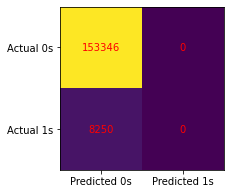

In [51]:
cm = metrics.confusion_matrix(y_test, y_pred_log)
print(cm)

fig, ax = plt.subplots(figsize=(3, 3))
ax.imshow(cm)
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
plt.show()

In [52]:
#y_test['target_005'] = y_test['probability'].apply(lambda x: 1 if x>=0.05 else 0)
#y_test['target_060'] = y_test['probability'].apply(lambda x: 1 if x>=0.6 else 0)
#y_test['target_080'] = y_test['probability'].apply(lambda x: 1 if x>=0.8 else 0)
#y_test['target_040'] = y_test['probability'].apply(lambda x: 1 if x>=0.4 else 0)
#y_test['target_060'] = y_test['probability'].apply(lambda x: 1 if x>=0.6 else 0)
#y_test['target_080'] = y_test['probability'].apply(lambda x: 1 if x>=0.8 else 0)
#y_test


In [57]:
y_test

,target
207774,1
251454,1
181783,0
330573,0
457925,0
...,...
131103,0
274322,0
290301,0
113724,0


In [62]:
modelling_data['userid'] = modelling_data['userid'].astype(int)
test_set = df_test.merge(modelling_data, on=['userid', 'currentbugroupname'], how='left')

In [65]:
test_results = logreg.predict(test_set[['last_31_day_fav_count', 'last_31_day_visit_count',
       'last_31_day_basket_count', 'last_31_day_order_quantity',
       'last_14_day_fav_count', 'last_14_day_visit_count',
       'last_14_day_basket_count', 'last_14_day_order_quantity',
       'last_10_day_fav_count', 'last_10_day_visit_count',
       'last_10_day_basket_count', 'last_10_day_order_quantity',
       'last_5_day_fav_count', 'last_5_day_visit_count',
       'last_5_day_basket_count', 'last_5_day_order_quantity',
       'last_3_day_fav_count', 'last_3_day_visit_count',
       'last_3_day_basket_count', 'last_3_day_order_quantity', 'bugroup_id',
       'userid']])

probs = logreg.predict_proba(test_set[['last_31_day_fav_count', 'last_31_day_visit_count',
       'last_31_day_basket_count', 'last_31_day_order_quantity',
       'last_14_day_fav_count', 'last_14_day_visit_count',
       'last_14_day_basket_count', 'last_14_day_order_quantity',
       'last_10_day_fav_count', 'last_10_day_visit_count',
       'last_10_day_basket_count', 'last_10_day_order_quantity',
       'last_5_day_fav_count', 'last_5_day_visit_count',
       'last_5_day_basket_count', 'last_5_day_order_quantity',
       'last_3_day_fav_count', 'last_3_day_visit_count',
       'last_3_day_basket_count', 'last_3_day_order_quantity', 'bugroup_id',
       'userid']])
prob = probs[:,1]
answer= test_set.copy()
answer['probability'] = prob.tolist()
answer['pred_target'] = test_results.tolist()

### FINAL ANSWER

In [68]:
answer[['userid', 'currentbugroupname', 'probability', 'target']]

,userid,currentbugroupname,probability,target
0,20152944,Private Label,0.042160,0
1,6662068,Private Label,0.262608,0
2,11941706,Private Label,0.135794,0
3,12406170,Private Label,0.127566,0
4,20939786,Private Label,0.037501,0
...,...,...,...,...
244831,24094896,Digital Goods,0.023336,0
244832,3625552,Digital Goods,0.363114,0
244833,17383254,Digital Goods,0.063329,0
244834,26909708,Digital Goods,0.015212,0


## FUTURE WORK

- I would implement an algorithm that will work on datasets of different time periods. For example, on the graph where I demonstrate the total purchase over a month we see sudden peaks which refers to a significant increase in the sales. These increases can be attributed to specific sales periods such as christmas, black friday, mother's day etc. A different model could be trained for these campaign periods or a new feature can be created. 

- Search terms could have been used as another feature.